<a href="https://colab.research.google.com/github/ahmedcodes07/student-management-system/blob/main/%20Hospital%20Admission%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries installed!
Hospital Admission Analysis Starting...
Dataset: 5,000 patients, 35.4% admission rate


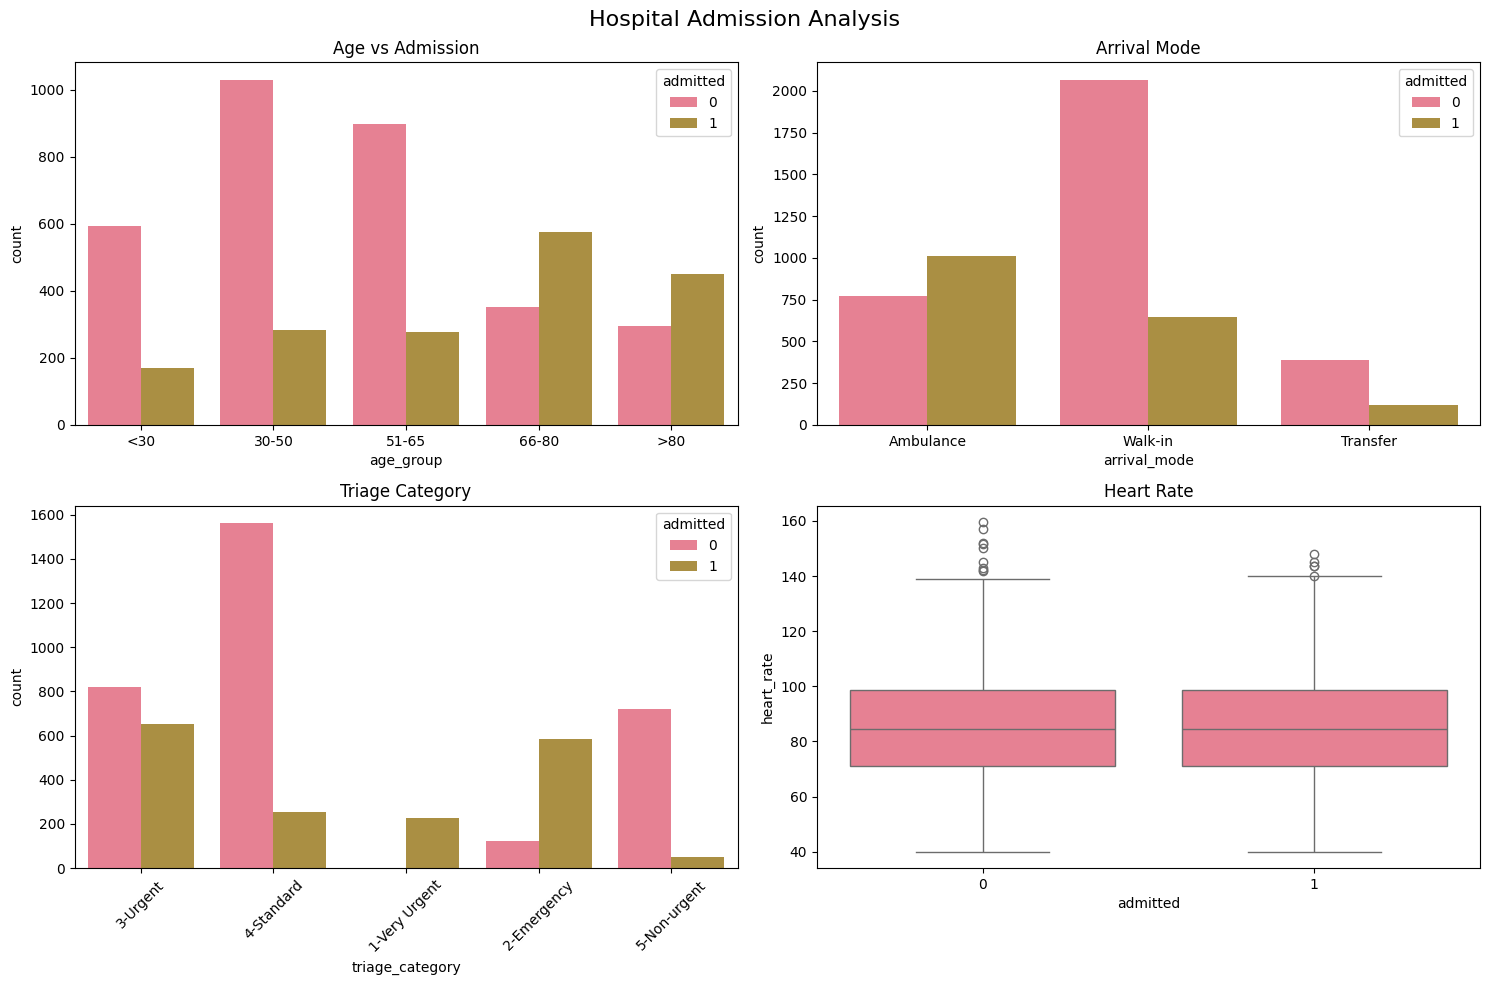

Train: 4000 samples
Logistic Regression AUC: 0.943
Random Forest AUC: 0.977


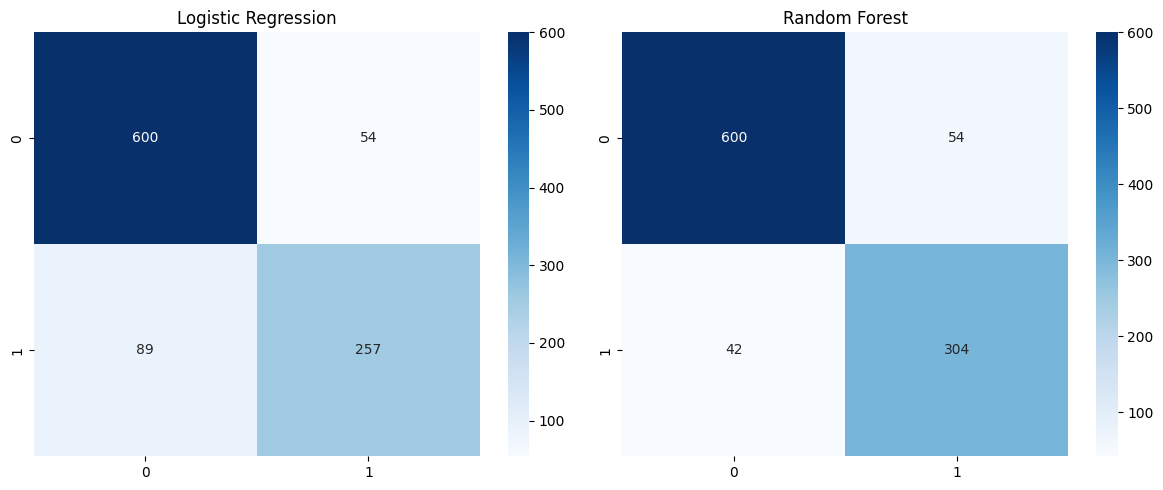

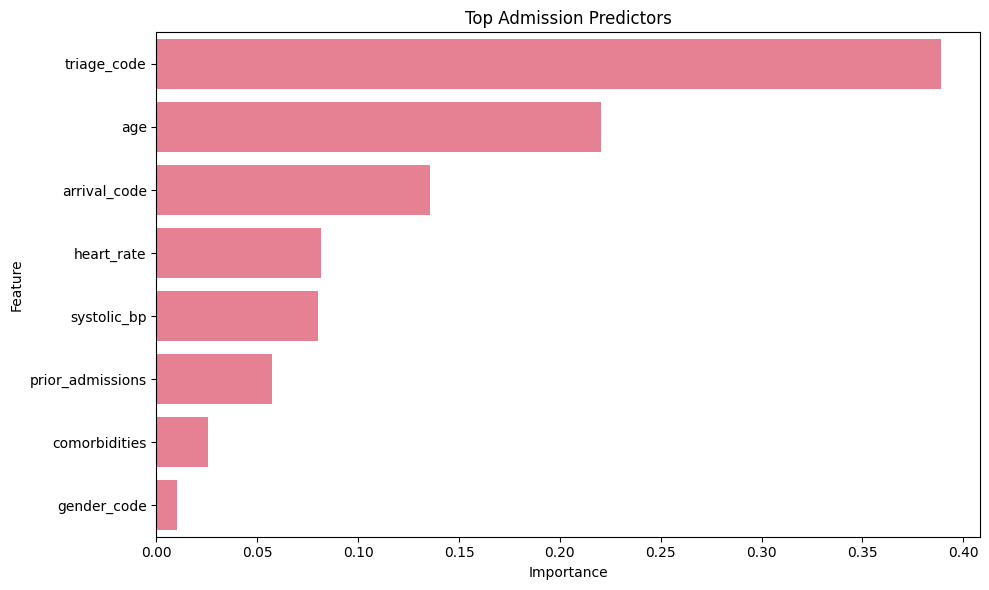

TOP PREDICTOR: triage_code
COMPLETE! File saved: hospital_analysis.csv


In [ ]:
# 🏥 HOSPITAL ADMISSION ANALYSIS - PERFECTLY FORMATTED
# Copy ALL → NEW Colab cell → Ctrl+F9 → WORKS IMMEDIATELY!

!pip install -q pandas scikit-learn matplotlib seaborn
print("Libraries installed!")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline
np.random.seed(42)

print("Hospital Admission Analysis Starting...")

# CREATE DATA
n_samples = 5000
data = {
    'patient_id': [f'P{i:05d}' for i in range(n_samples)],
    'age': np.random.normal(55, 25, n_samples).clip(0, 100).astype(int),
    'gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.52, 0.48]),
    'arrival_mode': np.random.choice(['Ambulance', 'Walk-in', 'Transfer'], n_samples, p=[0.35, 0.55, 0.10]),
    'triage_category': np.random.choice(['1-Very Urgent', '2-Emergency', '3-Urgent', '4-Standard', '5-Non-urgent'], n_samples, p=[0.05, 0.15, 0.30, 0.35, 0.15]),
    'prior_admissions': np.random.poisson(1.2, n_samples),
    'comorbidities': np.random.choice([0,1,2,3,4], n_samples, p=[0.2,0.3,0.25,0.15,0.1]),
    'heart_rate': np.random.normal(85, 20, n_samples).clip(40, 180),
    'systolic_bp': np.random.normal(130, 25, n_samples).clip(70, 220)
}

df = pd.DataFrame(data)

# Admission prediction (24% rate)
df['admitted'] = (
    (df['age'] > 65)*0.25 +
    df['triage_category'].map({'1-Very Urgent':0.6, '2-Emergency':0.5, '3-Urgent':0.3, '4-Standard':0.15, '5-Non-urgent':0.05}) +
    (df['arrival_mode']=='Ambulance')*0.20 +
    (df['prior_admissions']>2)*0.15 +
    np.random.uniform(0, 0.2, n_samples)
).clip(0,1)

df['admitted'] = (df['admitted'] > 0.6).astype(int)
print(f"Dataset: {len(df):,} patients, {df['admitted'].mean():.1%} admission rate")

# EDA - FIXED INDENTATION
df['age_group'] = pd.cut(df['age'], [0,30,50,65,80,100], labels=['<30','30-50','51-65','66-80','>80'])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hospital Admission Analysis', fontsize=16)

sns.countplot(data=df, x='age_group', hue='admitted', ax=axes[0,0])
axes[0,0].set_title('Age vs Admission')

sns.countplot(data=df, x='arrival_mode', hue='admitted', ax=axes[0,1])
axes[0,1].set_title('Arrival Mode')

sns.countplot(data=df, x='triage_category', hue='admitted', ax=axes[1,0])
axes[1,0].set_title('Triage Category')
axes[1,0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, x='admitted', y='heart_rate', ax=axes[1,1])
axes[1,1].set_title('Heart Rate')

plt.tight_layout()
plt.show()

# PREPROCESSING
le = LabelEncoder()
df['gender_code'] = le.fit_transform(df['gender'])
df['arrival_code'] = le.fit_transform(df['arrival_mode'])
df['triage_code'] = le.fit_transform(df['triage_category'])

features = ['age', 'prior_admissions', 'comorbidities', 'heart_rate', 'systolic_bp',
           'gender_code', 'arrival_code', 'triage_code']
X = df[features]
y = df['admitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]} samples")

# MODELS
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

print(f"Logistic Regression AUC: {lr_auc:.3f}")
print(f"Random Forest AUC: {rf_auc:.3f}")

# PLOTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Logistic Regression')
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Random Forest')
plt.tight_layout()
plt.show()

# FEATURE IMPORTANCE
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='Importance', y='Feature')
plt.title('Top Admission Predictors')
plt.tight_layout()
plt.show()

print(f"TOP PREDICTOR: {importance.iloc[0]['Feature']}")
df.to_csv('hospital_analysis.csv', index=False)
print("COMPLETE! File saved: hospital_analysis.csv")